<a href="https://colab.research.google.com/github/sehan25/ESAA-2022-1/blob/main/Study/Dacon-%EB%B2%84%EC%8A%A4_%EC%9A%B4%ED%96%89%EC%8B%9C%EA%B0%84_%EC%98%88%EC%B8%A1_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C_2%EC%9C%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 라이브러리 및 데이터 불러오기

In [1]:
import numpy as np # 행렬 연산 / 데이터 핸들링
import pandas as pd # 데이터 분석
import matplotlib.pyplot as plt # 그래프 시각화
import seaborn as sns # 그래프 시각화
from xgboost import XGBRegressor # XGBoost Regressor 모델
from sklearn.model_selection import KFold # K-validation
from sklearn.metrics import accuracy_score # 정확도 측정 함수
from sklearn.preprocessing import LabelEncoder # 라벨 인코더

from google.colab import drive
drive.mount('/content/drive')

#사용할 데이터 불러오기
train_data = pd.read_csv('/content/drive/MyDrive/ESAA/data/dacon/버스_운행시간_예측_경진대회_data/train.csv') 
test_data = pd.read_csv('/content/drive/MyDrive/ESAA/data/dacon/버스_운행시간_예측_경진대회_data/test.csv')
train_data.head(5)

Mounted at /content/drive


,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64


## 데이터 전처리

- 이상치 제거
    - 가장 먼 distance의 next_arrive_time이 600이므로 그 이외 너무 큰 시간을 소비하는 구간은 측정 오류로 판단

In [2]:
train_data = train_data[train_data['next_arrive_time'] < 700]
train_data.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64


- station명 인코딩
    - XGBoost는 숫자 데이터만 취급하므로 정류장 이름을 LabelEncoder를 이용해 치환

In [3]:
station_encoder = LabelEncoder()

_station = list(train_data['now_station'].values) + list(train_data['next_station'].values) # 모든 정류장(현재,다음)명 리스트
station_set = set(_station)
print(len(station_set))
station_encoder.fit(list(station_set)) # 인코딩

# train, test 데이터 staion명 치환
train_data['now_station'] = station_encoder.transform(train_data['now_station'])
train_data['next_station'] = station_encoder.transform(train_data['next_station'])
test_data['now_station'] = station_encoder.transform(test_data['now_station'])
test_data['next_station'] = station_encoder.transform(test_data['next_station'])
train_data.head()

351


,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,239,06시,266.0,227,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,227,06시,333.0,228,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,228,06시,415.0,235,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,41,06시,578.0,249,33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,63,07시,374.0,221,33.485822,126.490897,64


## EDA (탐색적 자료 분석)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)


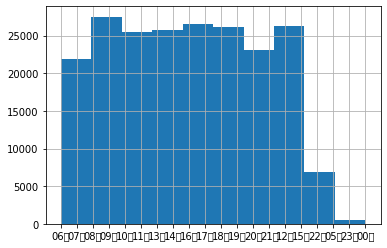

In [4]:
# 도착 시간 분포 확인
times_ = train_data['now_arrive_time']
times_.hist()

    도착 시간 분포 확인 결과, 01시 ~ 04시의 데이터가 존재하지 않음을 확인함. '시간대' feature을 만들 때 '새벽'은 추가하지 않는 것으로 결정함.

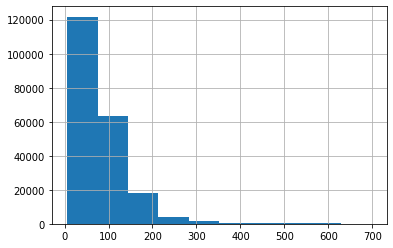

In [5]:
# 예측 시간 분포 확인
target_ = train_data['next_arrive_time']
target_.hist()

    분포 확인 확인 결과 다수의 데이터들이 0 ~ 200 정도의 분포를 띄고 있음을 알 수 있음. 700으로 target 값을 잘라낸 것이 유용하다고 판단됨.

## 변수 선택 및 모델 구축

### 변수 선택

- 날짜 -> 요일 -> 평일/주말 변환
    - datetime을 이용하여 각 날짜를 요일로 변환하고, 이를 바탕으로 평일과 주말, 두 그룹으로 분류

In [6]:
## train data

train_data['date'] = pd.to_datetime(train_data['date']) # datetime형으로 변환
train_data['weekday'] = train_data['date'].dt.weekday  # 월요일: 0, 일요일: 6
train_data['weekday'] = train_data['weekday'].apply(lambda x: 0 if x < 5 else 1) # 평일: 0, 주말: 1로 설정

train_data = pd.get_dummies(train_data, columns=['weekday']) # 평일/주말에 대해 One-Hot Encoding

train_data = train_data.drop('date', axis=1) # 기존의 date 칼럼은 삭제
train_data.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,weekday_0,weekday_1
0,0,405136001,7997025,360-1,33.456267,126.551750,239,06시,266.0,227,33.457724,126.554014,24,1,0
1,1,405136001,7997025,360-1,33.457724,126.554014,227,06시,333.0,228,33.458783,126.557353,36,1,0
2,2,405136001,7997025,360-1,33.458783,126.557353,228,06시,415.0,235,33.459893,126.561624,40,1,0
3,3,405136001,7997025,360-1,33.479705,126.543811,41,06시,578.0,249,33.484860,126.542928,42,1,0
4,4,405136001,7997025,360-1,33.485662,126.494923,63,07시,374.0,221,33.485822,126.490897,64,1,0


In [7]:
## test data

test_data['date'] = pd.to_datetime(test_data['date'])
test_data['weekday'] = test_data['date'].dt.weekday
test_data['weekday'] = test_data['weekday'].apply(lambda x: 0 if x < 5 else 1)
test_data = pd.get_dummies(test_data, columns=['weekday'])

test_data = test_data.drop('date', axis=1)
test_data.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,weekday_0,weekday_1
0,210457,405136001,7997025,360-1,33.457724,126.554014,227,07시,333.0,228,33.458783,126.557353,1,0
1,210458,405136001,7997025,360-1,33.458783,126.557353,228,07시,415.0,235,33.459893,126.561624,1,0
2,210459,405136001,7997025,360-1,33.478867,126.483833,323,08시,417.0,59,33.478850,126.488350,1,0
3,210460,405136001,7997025,360-1,33.478850,126.488350,59,08시,334.0,183,33.480700,126.489933,1,0
4,210461,405136001,7997025,360-1,33.480700,126.489933,183,08시,550.0,285,33.482077,126.485355,1,0


- 정류장 출발 시간 세 그룹으로 변환
    - 기존 시간을 24개로 두게 되면 모델의 복잡도가 증가할 수 있으므로 과적합을 막기 위해 아침/오후/저녁 세 그룹으로 분류 후 One-Hot Encoding

In [8]:
## train data

train_data['time_group']='group' # time_group 변수를 미리 생성

train_data.loc[ (train_data['now_arrive_time']>='05시') & (train_data['now_arrive_time']<'12시') ,['time_group'] ]= 'morning' # 아침: 05 ~ 11시
train_data.loc[ (train_data['now_arrive_time']>='12시') & (train_data['now_arrive_time']<'18시') ,['time_group'] ]= 'afternoon' # 오후: 12 ~ 17시
train_data.loc[ (train_data['now_arrive_time']>='18시') | (train_data['now_arrive_time']=='00시'),['time_group'] ]= 'evening' # 저녁: 18 ~ 00시

train_data = pd.get_dummies(train_data,columns=['time_group']) # 아침/오후/저녁 One-Hot Encoding
train_data = train_data.drop('now_arrive_time', axis=1) # 기존의 now_arrive_time 칼럼은 삭제
train_data.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,distance,next_station,next_latitude,next_longitude,next_arrive_time,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,0,405136001,7997025,360-1,33.456267,126.551750,239,266.0,227,33.457724,126.554014,24,1,0,0,0,1
1,1,405136001,7997025,360-1,33.457724,126.554014,227,333.0,228,33.458783,126.557353,36,1,0,0,0,1
2,2,405136001,7997025,360-1,33.458783,126.557353,228,415.0,235,33.459893,126.561624,40,1,0,0,0,1
3,3,405136001,7997025,360-1,33.479705,126.543811,41,578.0,249,33.484860,126.542928,42,1,0,0,0,1
4,4,405136001,7997025,360-1,33.485662,126.494923,63,374.0,221,33.485822,126.490897,64,1,0,0,0,1


In [9]:
## test data

test_data['time_group']='group'

test_data.loc[ (test_data['now_arrive_time']>='05시') & (test_data['now_arrive_time']<'12시') ,['time_group'] ]= 'morning'
test_data.loc[ (test_data['now_arrive_time']>='12시') & (test_data['now_arrive_time']<'18시') ,['time_group'] ]= 'afternoon'
test_data.loc[ (test_data['now_arrive_time']>='18시') | (test_data['now_arrive_time']=='00시'),['time_group'] ]= 'evening'

test_data = pd.get_dummies(test_data,columns=['time_group'])
test_data = test_data.drop('now_arrive_time', axis=1)
test_data.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,distance,next_station,next_latitude,next_longitude,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,210457,405136001,7997025,360-1,33.457724,126.554014,227,333.0,228,33.458783,126.557353,1,0,0,0,1
1,210458,405136001,7997025,360-1,33.458783,126.557353,228,415.0,235,33.459893,126.561624,1,0,0,0,1
2,210459,405136001,7997025,360-1,33.478867,126.483833,323,417.0,59,33.478850,126.488350,1,0,0,0,1
3,210460,405136001,7997025,360-1,33.478850,126.488350,59,334.0,183,33.480700,126.489933,1,0,0,0,1
4,210461,405136001,7997025,360-1,33.480700,126.489933,183,550.0,285,33.482077,126.485355,1,0,0,0,1


- 불필요한 피처 제거
    - id는 학습에서 의미 없는 피처이므로 제거
    - route_nm은 route_id와 같은 역할의 데이터이므로 중복으로 판단하여 제거
    - latitude, longitude는 큰 의미 없으며 모델의 복잡도를 높일 수 있다고 판단하여 제거

In [10]:
## train data
train_data = train_data.drop(['id', 'route_nm', 'next_latitude', 'next_longitude', 
                              'now_latitude', 'now_longitude'], axis=1)
train_data.head()

,route_id,vh_id,now_station,distance,next_station,next_arrive_time,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,405136001,7997025,239,266.0,227,24,1,0,0,0,1
1,405136001,7997025,227,333.0,228,36,1,0,0,0,1
2,405136001,7997025,228,415.0,235,40,1,0,0,0,1
3,405136001,7997025,41,578.0,249,42,1,0,0,0,1
4,405136001,7997025,63,374.0,221,64,1,0,0,0,1


In [11]:
## test data
test_data = test_data.drop(['route_nm', 'next_latitude', 'next_longitude', 
                              'now_latitude', 'now_longitude'], axis=1) # 제출 파일 생성 시 id 필요하므로 제거X
test_data.head()

,id,route_id,vh_id,now_station,distance,next_station,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,210457,405136001,7997025,227,333.0,228,1,0,0,0,1
1,210458,405136001,7997025,228,415.0,235,1,0,0,0,1
2,210459,405136001,7997025,323,417.0,59,1,0,0,0,1
3,210460,405136001,7997025,59,334.0,183,1,0,0,0,1
4,210461,405136001,7997025,183,550.0,285,1,0,0,0,1


### 학습 데이터 구성

In [12]:
# target 칼럼 next_arrive_time 제외
input_var = list(train_data.columns) 
input_var.remove('next_arrive_time')

Xtrain = train_data[input_var] # next_arrive_time 제외한 칼럼
Ytrain = train_data['next_arrive_time'] # target 값인 next_arrive_time 칼럼

Xtest = test_data[input_var] # next_arrive_time 제외한 칼럼

### 모델 구축 및 학습 준비

- 빠른 학습과 정밀도를 보장하는 eXtreme Gradient Boosting 사용
    - K-Fold를 이용하여 K-Validation을 수행(random seed는 Regressor 110, KFold 777 고정)

In [13]:
model = XGBRegressor(random_state=110, verbosity=0, nthread=23, n_estimators=980, max_depth=4)
kfold = KFold(n_splits=8, shuffle=True, random_state=777)
n_iter = 0
cv_score = []

def rmse(target, pred):
    return np.sqrt(np.sum(np.power(target - pred, 2)) / np.size(pred))

## 모델 학습 및 검증

In [14]:
for train_index, test_index in kfold.split(Xtrain, Ytrain):

    # K Fold가 적용된 train, test 데이터
    X_train, X_test = Xtrain.iloc[train_index,:], Xtrain.iloc[test_index, :]
    Y_train, Y_test = Ytrain.iloc[train_index], Ytrain.iloc[test_index]
    
    # 모델 학습 및 예측
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    print(pred)
    
    # RMSE 측정
    n_iter += 1
    score = rmse(Y_test, pred)
    print(score)
    cv_score.append(score)

print('\n교차 검증별 RMSE :', np.round(cv_score, 4))
print('평균 검증 RMSE :', np.mean(cv_score))

[119.67842   53.366745  64.12135  ...  36.824852 552.24896   29.85703 ]
31.682995419818774
[52.23959  56.84924  96.848114 ... 89.35416  65.19819  21.766693]
32.55762373054107
[143.30948 108.65616 101.28503 ... 102.84548 114.65369 232.3917 ]
32.209933600214455
[68.71044  69.58528  95.9982   ... 27.40541  61.493267 79.65983 ]
31.88248158841925
[ 37.024693  72.0255    64.37581  ...  75.1468   103.63872   22.747555]
32.263149246257406
[ 50.96657  133.87277  127.117165 ...  86.01084   75.5694    38.827362]
32.43904335419425
[ 31.833994 128.58534  100.39982  ...  83.00587  100.06998   65.981575]
31.851952509364576
[183.38222   36.711113  49.343643 ...  33.166195  70.43415  122.909065]
32.089345491251244

교차 검증별 RMSE : [31.683  32.5576 32.2099 31.8825 32.2631 32.439  31.852  32.0893]
평균 검증 RMSE : 32.12206561750763


- 피처 중요도 분석
    - 해당 데이터를 중심으로 feature engineering을 진행해보기 위함.

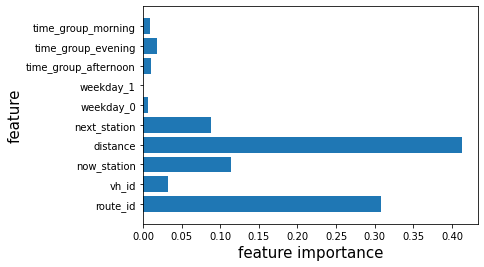

1.0000001

In [24]:
n_feature = X_train.shape[1]
index = np.arange(n_feature)

plt.barh(index, model.feature_importances_, align='center') #
plt.yticks(index, input_var)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()
np.sum(model.feature_importances_)

    distance가 가장 중요한 판단 피처로 보이며, 버스 노선 id 또한 중요한 피처로 보임.(지역적 위치 정보도 반영되는 듯함)
    출발/도착 정류장 종류도 유의미한 가중치 가짐

## 결과 예측 및 제출

In [25]:
result = model.predict(Xtest) # test 데이터 예측

test_data['next_arrive_time'] = result # next_arrive_time 칼럼에 예측 결과로 추가
test_data[['id', 'next_arrive_time']].to_csv('result.csv',index=False, float_format='%.14f') # csv로 변환